# Random Ronchigram generator

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [2]:
# GPT related libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated') 
saveResultsQ = False
import scipy
# import cv2

failed to import parallelstuff


In [5]:
# CNN related libraries
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


## Get CNN model ready

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [7]:
# VGG16 model with self-defined top fully-connected layers
# training data: 50,000 frames of simulated Ronchigrams, 70 mrad collection angle, 100 mrad simulation range, fine aberration range
# training hyper-parameters: 
#  learning rate: 8.5e-5/5.5e-5
#  decay: 1e-7
#  momentum: 0.9
#  batch size: 20
#  training epoch: 50/100

model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
print('Model loaded')
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.0))
top_model.add(Dense(1,activation=None))

new_model = Sequential()
for l in model.layers:
    new_model.add(l)
new_model.add(top_model)

Model loaded


In [8]:
new_model.load_weights('CNNmodels/VGG16.h5')
model = new_model
del top_model, new_model

In [9]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input  

### Creat the machine interface

In [4]:
ndim = 2
ronch = []
emit = []

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[1998.216, 0.4]]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
# get emittance from getState() return value
emit.append(mi.getState()[1][0][0])
# get ronchigram from saved npy file
if ~os.path.exists('ronchigram.npy'):
    time.sleep(1)
temp = np.load('ronchigram.npy')
# temp = temp[50:150,50:150]
# temp = cv2.resize(temp,(128,128))

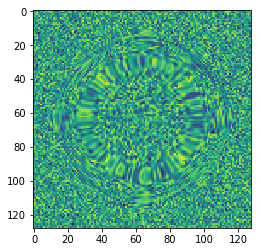

In [5]:
plt.imshow(temp)

In [11]:
ndim = 4 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
reps = 100  # number of times to repeat the GPT simulation with random status

# upper boundary and lower boundary for H1, H2, S3, S4, S5, S6 determined from Ronchigrams.
# These ranges are pretty large, will generate Ronchigrams that looks terrible without flat area at the boundary.
upper_bound = np.asarray([2000, 35, 4.0e5, -6.3e5])
lower_bound = np.asarray([500, -35, 3.8e5, -6.8e5])
mid = upper_bound + lower_bound

# Run GPT simulation 'reps' times
ronch = []
emit = []
start_point = [[0,0,0,0]]

for i in range(reps):
    rs = np.random.RandomState()
    for j in range(upper_bound.shape[0]):
        start_point[0][j] = (rs.random() - 0.5) * (upper_bound[j] - lower_bound[j]) + mid[j]
#     print(start_point)
    #creat machine interface
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    # get emittance from getState() return value
    emit.append(mi.getState()[1][0][0])
    # get ronchigram from saved npy file
    if ~os.path.exists('ronchigram.npy'):
        time.sleep(1)
    # Make sure the output Ronchigram is set to 128px for CNN
    temp = np.load('ronchigram.npy')
    ronch.append(temp)
    clear_output(wait=True)
    plt.imshow(temp)
    plt.show()
    os.remove('ronchigram.npy')

/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: The length of x, y and z should be at least (kx+1) * (ky+1)

In [12]:
i

0